# Setup

In [1]:
import mss
import numpy as np
import cv2
import pydirectinput
import matplotlib.pyplot as plt

import time  # to delay screenshot

import color_mask as mask
import pathfinding

# Fetch Screenshot

In [ ]:
# Grab screenshot
time.sleep(2)

height = 1000
width = 1000
global_map = np.zeros((height, width), dtype=np.uint8)

with mss.mss() as sct:

    # get minimap screenshot
    minimap_region = {"top": 0, "left": 2027, "width": 531, "height": 545}
    minimap_ss = np.array(sct.grab(minimap_region))
    cv2.imshow("minimap", cv2.cvtColor(minimap_ss, cv2.COLOR_BGRA2BGR))
    cv2.waitKey(0)

    # get game window screenshot
    game_region = {"top": 0, "left": 0, "width": 2025, "height": 1600}
    game_ss = np.array(sct.grab(game_region))
 
    # # Debug: Getting minimap pixel region
    # cv2.imshow("minimap", cv2.cvtColor(boss_ss, cv2.COLOR_BGRA2BGR))
    # cv2.waitKey(0)




# Color Masks

## Template Matching

In [36]:
template = cv2.imread('sprites/boss_icon.png', cv2.IMREAD_GRAYSCALE)

game_bgr = np.array(game_ss)[:,:,:3].copy()
game_gray = cv2.cvtColor(game_bgr, cv2.COLOR_BGR2GRAY)

result = cv2.matchTemplate(game_gray, template, cv2.TM_CCOEFF_NORMED)

_, max_val, _, max_loc = cv2.minMaxLoc(result)

h, w = template.shape
center_x = max_loc[0] + w // 2
center_y = max_loc[1] + h // 2

# Draw a dot at that center
cv2.circle(game_bgr, (center_x, center_y), radius=5, color=(0, 0, 255), thickness=-1)

# Show the result
cv2.imshow("Match Dot", game_bgr)
cv2.waitKey(0)
cv2.destroyAllWindows()

print(f"Best match at: ({center_x}, {center_y}) with confidence {max_val:.3f}")

Best match at: (529, 477) with confidence 0.791


## Walkable Poi Mask

In [ ]:
hsv_map = cv2.cvtColor(minimap_ss, cv2.COLOR_BGR2HSV)

# holds HSV values of poi's
tile_hsvs = {
    "sand_room": np.array([16, 81, 163]),
    "bridge/room": np.array([12, 98, 120]),
    "player": np.array([0, 0, 255]),
    "ship_room": np.array([170, 61, 63]),
    "enemies": np.array([0, 255, 255])
}

poi_masks = {}
for name, hsv in tile_hsvs.items():
    mask = cv2.inRange(hsv_map, hsv, hsv)
    poi_masks[name] = mask

print(list(poi_masks.values())[0].shape)
combined_mask = np.zeros(list(poi_masks.values())[0].shape, dtype=np.uint8)
for m in poi_masks.values():
    combined_mask = cv2.bitwise_or(combined_mask, m)
    

(545, 531)


-1

## Walkable Space

In [4]:
def get_walkable_tiles(minimap_ss):
    hsv_map = cv2.cvtColor(minimap_ss, cv2.COLOR_BGR2HSV)

    tile_hsvs = {
        "sand_room": np.array([16, 81, 163]),
        "bridge": np.array([12, 98, 120]),
        "player": np.array([0, 0, 255]),
        "ship_room": np.array([170, 61, 63]),
    }

    combined_tiles = np.zeros(hsv_map.shape[:2], dtype=np.uint8)

    tile_masks = {}
    for name, hsv in tile_hsvs.items():
        mask = cv2.inRange(hsv_map, hsv, hsv)
        tile_masks[name] = mask
        combined_tiles = cv2.bitwise_or(combined_tiles, mask)
    
    # Fill in center as walkable since arrow covers it up
    center_row, center_col = hsv_map.shape[0] // 2, hsv_map.shape[1] // 2
    cv2.rectangle(
        combined_tiles,
        (center_col - 13, center_row - 35),
        (center_col + 15, center_row + 17),
        color=255,
        thickness=-1
    )
    
    return combined_tiles

# Room Centroids

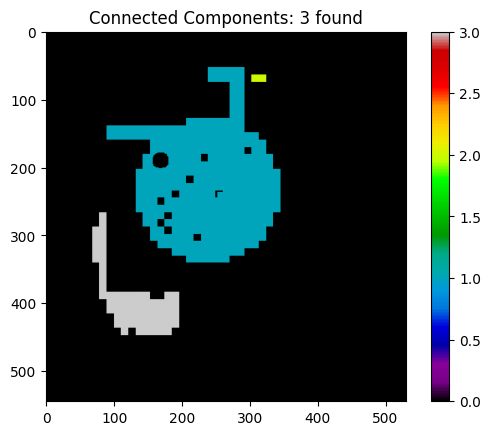

In [5]:
walkable_tiles = get_walkable_tiles(minimap_ss)

num_labels, labels = cv2.connectedComponents(walkable_tiles)

plt.imshow(labels, cmap='nipy_spectral')
plt.title(f"Connected Components: {num_labels - 1} found")
plt.colorbar()
plt.show()

input()
# fill in small obstacles
kernel = np.ones((20,20), np.uint8)
map_filled = cv2.morphologyEx(walkable_tiles, cv2.MORPH_CLOSE, kernel)

# filter out corridors by only looking at bigger distances
dist = cv2.distanceTransform(map_filled.astype(np.uint8), cv2.DIST_L2, 5)
room_mask = (dist > 13).astype(np.uint8) * 255

# get connected components
num_labels, labels = cv2.connectedComponents(room_mask)

# get center point to filter out spawn centroid
height, width = minimap_ss.shape[:2]
spawn_label = labels[height // 2, width // 2]

centroids = []
for label in range(1, num_labels):

    if label != spawn_label:
        mask = (labels == label).astype(np.uint8)
        M = cv2.moments(mask)

        if M["m00"] != 0:
            cx = M["m10"] / M["m00"]
            cy = M["m01"] / M["m00"]
            centroids.append(np.array([cx, cy]))


# Draw centroids on top
map_vis = cv2.cvtColor((map_filled).astype(np.uint8), cv2.COLOR_GRAY2BGR)
for cx, cy in centroids:
    cv2.circle(map_vis, (int(cx), int(cy)), radius=5, color=(0,0,255), thickness=-1)  # red dots

cv2.imshow("Walkable Tiles with Centroids", map_vis)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Room Vectors

In [34]:
def get_room_vectors(room_centroids, minimap):
    height, width = minimap.shape[:2]
    player = np.array([width // 2, height // 2])

    room_coord_to_vec = {}
    room_vec_to_coord = {}
    for room in room_centroids:
        room_vec = room - player

        # convert to tuple's to use as keys in dict
        coord_tuple = tuple(room)
        vec_tuple = tuple(room_vec)
        
        room_coord_to_vec[coord_tuple] = vec_tuple
        room_vec_to_coord[vec_tuple] = coord_tuple
        # room_vec = room_vec / np.linalg.norm(room_vec)
    
    return room_coord_to_vec, room_vec_to_coord

In [ ]:
# convert centroids to vectors
room_coord_to_vec, room_vec_to_coord = get_room_vectors(centroids, minimap_ss)


# display vectors
height, width = minimap_ss.shape[:2]
player = [width // 2, height // 2]

room_vec_test = minimap_ss.copy()

for vec in room_vec_to_coord.keys():
    end_point = (int(player[0] + vec[0]), int(player[1] + vec[1]))  # adds vector to current player pos to turn into x,y coord

    cv2.arrowedLine(
        room_vec_test,
        player,
        end_point,
        color=(0,255,0),
        thickness=2,
        tipLength=0.2
    )

cv2.imshow("Room Vectors Test", room_vec_test)
cv2.waitKey(0)
cv2.destroyAllWindows()
    

## Get Boss Heading

In [7]:
def get_boss_heading(game_ss):
    hsv_map = cv2.cvtColor(game_ss, cv2.COLOR_BGR2HSV)
    height, width = hsv_map.shape[:2]
    player = [width // 2, height // 2]

    hsv_lower = np.array([4, 150, 150])
    hsv_upper = np.array([7, 250, 250])
    mask = cv2.inRange(hsv_map, hsv_lower, hsv_upper)

    # Get moments for image
    M = cv2.moments(mask, binaryImage = True)

    if M["m00"] > 0:
        cx = M["m10"] / M["m00"]
        cy = M["m01"] / M["m00"]
        average_point = np.array([cx, cy])

        heading_vec = average_point - player
        # heading_vec = heading_vec / np.linalg.norm(heading_vec)
    else:
        heading_vec = None

    return heading_vec

In [8]:
boss_heading = get_boss_heading(game_ss)


# display boss heading
height, width = minimap_ss.shape[:2]
player = [width // 2, height // 2]

boss_heading_test = minimap_ss.copy()

end_point = (int(player[0] + boss_heading[0]*0.2), int(player[1] + boss_heading[1]*0.2))  # scaled since based on game ss and not minimap ss

cv2.arrowedLine(
    boss_heading_test,
    player,
    end_point,
    color=(0,255,0),
    thickness=2,
    tipLength=0.2
)

cv2.imshow("Boss Heading Test", boss_heading_test)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Get Best Room

In [9]:
def get_best_room_heading(room_vectors, boss_heading):
    dots = [np.dot(r, boss_heading) for r in room_vectors]
    return room_vectors[np.argmax(dots)]

In [ ]:
best_room_vec = get_best_room_heading(list(room_vec_to_coord.keys()), boss_heading)

# Visualize all rooms
best_room_vec_test = minimap_ss.copy()
for cx, cy in centroids:
    cv2.circle(best_room_vec_test, (int(cx), int(cy)), radius=5, color=(0,0,255), thickness=-1)  # red dots

# draw ideal room arrow
height, width = minimap_ss.shape[:2]
player = (height // 2, width // 2)
ideal_room = (int(player[0] + best_room_vec[0]), int(player[1] + best_room_vec[1]))
cv2.arrowedLine(
    best_room_vec_test,
    player,
    ideal_room,
    color=(0,255,0),
    thickness=2,
    tipLength=0.2
)

cv2.imshow("Best Room Vector Test", best_room_vec_test)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Pathfinding To Best Room

In [11]:
def downsample_mask(mask, block_size=5):
    """
    mask: boolean array of shape (H, W)
    block_size: number of pixels per grid cell
    """

    H, W = mask.shape
    new_H = H // block_size
    new_W = W // block_size

    # Initialize smaller grid
    grid = np.zeros((new_H, new_W), dtype=bool)

    for i in range(new_H):
        for j in range(new_W):
            block = mask[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
            grid[i, j] = np.all(block)  # True if all pixels are walkable

    return grid

def resize_print(img, scale):
    return cv2.resize(img, (img.shape[1]*scale, img.shape[0]*scale), interpolation=cv2.INTER_NEAREST)

96


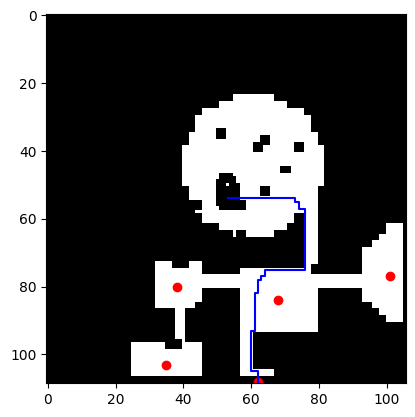

In [28]:
from skimage.graph import route_through_array


# shrink map (issue with keypresses can only be so quick, smaller map = less path points returned = more accurate for key press to grid tile)
scale = 5
walkable_tiles = get_walkable_tiles(minimap_ss)
walkable_tiles_small = downsample_mask(walkable_tiles, block_size=scale)

# # DEBUG: display smaller map to double check resolution after shrinking
# cv2.imshow("map", walkable_tiles)
# cv2.waitKey(0)
# img = (walkable_tiles_small.astype(np.uint8)) * 255
# cv2.imshow("map", resize_print(img, scale))
# cv2.waitKey(0)


# establish cost array (walkable has cost 1, not walkable has cost 1000)
cost_array = np.where(walkable_tiles_small, 1, 1000)

height, width = minimap_ss.shape[:2]
player = (height // (2*scale), width // (2*scale))


# map room vec to room cord
best_room_x, best_room_y = room_vec_to_coord[tuple(best_room_vec)]
end = (int(best_room_y // scale), int(best_room_x // scale))

# find least cost path to room
indices, cost = route_through_array(cost_array, start=player, end=end, fully_connected=False)


# showcase path
plt.imshow(walkable_tiles_small, cmap="gray")
for cx, cy in centroids:
    plt.plot(cx // scale, cy // scale, 'ro')

y, x = zip(*indices)
plt.plot(x, y, 'b-')

print(len(indices))

# Translate Path to Inputs

## Map Delta to Key

In [13]:
def map_delta_to_key(dr, dc):
    if dr == -1 and dc == 0:
        return 'w'
    elif dr == 1 and dc == 0:
        return 's' 
    elif dr == 0 and dc == -1:
        return 'a'  
    elif dr == 0 and dc == 1:
        return 'd'
    else:
        return None  # no movement


In [ ]:
import math

time.sleep(2)

for i in range(30):
    with mss.mss() as sct:
        # get new screenshot
        minimap_region = {"top": 0, "left": 2027, "width": 531, "height": 545}
        updated_minimap = np.array(sct.grab(minimap_region))

    height, width = updated_minimap.shape[:2]
    player = (height // (2*scale), width // (2*scale))

    closest_index = min(
        range(len(indices)),
        key=lambda i: math.dist(player, indices[i])
    )

    target = indices[closest_index + 1]

    dr = target[0] - player[0]
    dc = target[1] - player[1]

    key = map_delta_to_key(dr, dc)

    if key:
        pydirectinput.keyDown(key)
        time.sleep(0.00001)
        pydirectinput.keyUp(key)


Player at: (54, 53)
Player at: (54, 53)
Player at: (54, 53)
Player at: (54, 53)
Player at: (54, 53)
Player at: (54, 53)
Player at: (54, 53)
Player at: (54, 53)
Player at: (54, 53)
Player at: (54, 53)
Player at: (54, 53)
Player at: (54, 53)
Player at: (54, 53)
Player at: (54, 53)
Player at: (54, 53)
Player at: (54, 53)
Player at: (54, 53)
Player at: (54, 53)
Player at: (54, 53)
Player at: (54, 53)
Player at: (54, 53)
Player at: (54, 53)
Player at: (54, 53)
Player at: (54, 53)
Player at: (54, 53)
Player at: (54, 53)
Player at: (54, 53)
Player at: (54, 53)
Player at: (54, 53)
Player at: (54, 53)


In [ ]:
# translate coordinate path into keypresses
keys = []
time.sleep(2)
# for i in range(len(indices) - 1):
for i in range(1):
    current = indices[i]
    next = indices[i+1]
    delta_x = next[0] - current[0]
    delta_y = next[1] - current[1]

    key = pathfinding.map_delta_to_key(delta_x, delta_y)
    keys.append(key)

    # if key:
    #     start = time.perf_counter()
    #     pydirectinput.keyDown(key)
    #     while(time.perf_counter() - start) < (0.000000001 / 1000):
    #         pass
    #     pydirectinput.keyUp(key)

    # if key:
    #     pydirectinput.keyDown(key)
    #     time.sleep(0.00001)
    #     pydirectinput.keyUp(key)